In [52]:
# Todo: make 5d max min be stable after split_date, feature engineer the reeeeeeel Y

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import daytime as dt

""" Notes:
- Check if all registered locations are in the sea
- help models with 360 degrees directions
- check for all nans
- Extracheck that port locations are congruent
- Add hasScheldue, whether the ship has a schedule or not
- Add boolean isInPort, whether the ship is in port or not
- Add daysSinceDeparture
- Add lastDepartureLatitude, lastDepartureLongitude
- Add daysUntilArrival
- Add nextArrivalLatitude, nextArrivalLongitude
- Normalize all numerical values
"""

ais_train = pd.read_csv('ais_train.csv', sep='|')
ais_train['time'] = pd.to_datetime(ais_train['time']).dt.tz_localize(None)
print(ais_train.shape)
ais_train.head(5)

(1522065, 11)


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.00,0.70,0,88,0,01-09 23:00,-34.74,-57.85,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.60,0.00,-6,347,1,12-29 20:00,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.00,11.00,0,112,0,01-02 09:00,39.19,-76.48,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.40,0.00,0,142,1,12-31 20:00,-34.41,151.02,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.00,19.70,0,215,0,01-25 12:00,35.88,-5.92,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [53]:
# Add year to etaRaw and make it a datetime object
# If the month is august or later, make it 2023, else 2024
ais_train['etaRaw'] = pd.to_datetime('2024-' + ais_train['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')
ais_train['etaRaw'] = ais_train['etaRaw'].apply(lambda x: x.replace(year=2023) if x.month > 7 else x)

ais_train.head(5)


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.00,0.70,0,88,0,2024-01-09 23:00:00,-34.74,-57.85,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.60,0.00,-6,347,1,2023-12-29 20:00:00,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.00,11.00,0,112,0,2024-01-02 09:00:00,39.19,-76.48,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.40,0.00,0,142,1,2023-12-31 20:00:00,-34.41,151.02,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.00,19.70,0,215,0,2024-01-25 12:00:00,35.88,-5.92,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [54]:


# Show number, not 	1.522065e+06
pd.set_option('display.float_format', lambda x: '%.2f' % x)
ais_train.describe()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude
count,1522065,1522065.00,1522065.00,1522065.00,1522065.00,1522065.00,1518302,1522065.00,1522065.00
mean,2024-03-06 03:20:23.657231360,178.25,6.33,0.51,176.27,2.09,2024-03-05 13:55:54.755825920,36.58,11.54
min,2024-01-01 00:00:25,0.00,0.00,-127.00,0.00,0.00,2023-08-01 08:30:00,-47.53,-167.54
25%,2024-02-03 02:59:19,78.20,0.00,0.00,75.00,0.00,2024-02-02 12:00:00,34.52,-5.21
50%,2024-03-07 12:34:57,183.80,0.50,0.00,180.00,0.00,2024-03-06 23:59:00,42.23,4.23
75%,2024-04-07 07:37:36,269.00,14.10,0.00,265.00,5.00,2024-04-07 10:00:00,51.35,18.84
max,2024-05-07 23:59:08,360.00,102.30,128.00,511.00,15.00,2024-07-29 00:30:00,70.56,178.81
std,NaN,107.68,7.54,17.61,107.09,2.41,NaN,22.90,68.72


In [55]:
# 

In [56]:
schedules_to_may_2024 = pd.read_csv('schedules_to_may_2024.csv', sep='|')

schedules_to_may_2024['arrivalDate'] = pd.to_datetime(schedules_to_may_2024['arrivalDate']).dt.tz_localize(None)
schedules_to_may_2024['sailingDate'] = pd.to_datetime(schedules_to_may_2024['sailingDate']).dt.tz_localize(None)

#print(schedules_to_may_2024.shape)
#schedules_to_may_2024.head()

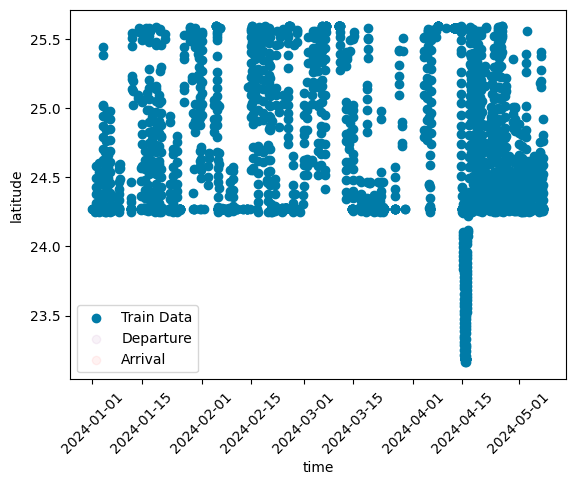

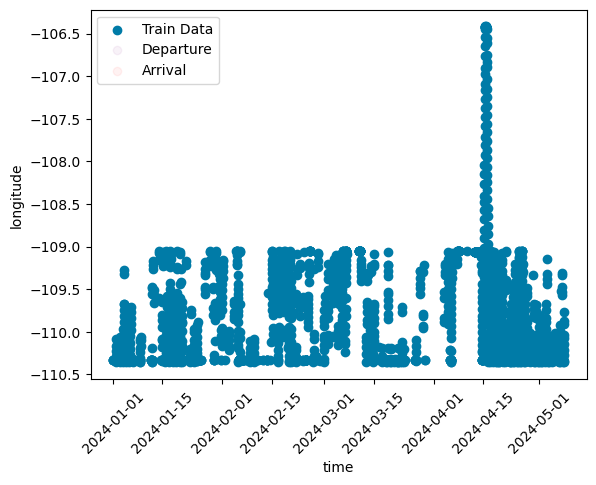

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude


In [57]:
# Filter the same vessel entries in ais_train and ais_test
def plotVessel(vessel_id='61e9f3aeb937134a3c4bfe3d', feature='latitude'):
    train_vessel = ais_train[ais_train['vesselId'] == vessel_id]
    schedule = schedules_to_may_2024[schedules_to_may_2024['vesselId'] == vessel_id]
    # remove entries from schedule that are earlier than the first entry in ais_train
    schedule = schedule[schedule['sailingDate'] > train_vessel['time'].min()]
    # Plot latitude vs time for ais_train as a scatter plot
    plt.scatter(train_vessel['time'], train_vessel[feature], label='Train Data', color='#007BA7')
    " Plot blue dots for the depature dates and dark bliue for the arrival dates"
    plt.scatter(schedule['sailingDate'], schedule['portLatitude'], label='Departure', color='purple', alpha=0.05)
    # Semitransparent dots for the arrival dates
    plt.scatter(schedule['arrivalDate'], schedule['portLatitude'], label='Arrival', color='red', alpha=0.05)
    plt.xticks(rotation=45)
    plt.xlabel('time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

plotVessel(vessel_id='61e9f468b937134a3c4c028f')
plotVessel(vessel_id='61e9f468b937134a3c4c028f', feature='longitude')
schedules_to_may_2024[schedules_to_may_2024['vesselId'] == '61e9f468b937134a3c4c028f'].head()
#plotVessel(feature='longitude')

In [58]:
# All vessels: ais_train['vesselId'].unique()

#print the first 10 sevvel Ids
print(ais_train['vesselId'].unique()[:10])

vesselsIdsToPredict = ais_train['vesselId'].unique()[:10]# ['61e9f468b937134a3c4c028f', '61e9f436b937134a3c4c0131']

vesselsToPredict = ais_train[ais_train['vesselId'].isin(vesselsIdsToPredict)]
vesselsToPredict.head()

# print unnique values for portId
print(vesselsToPredict['portId'].unique())


split_date = pd.Timestamp('2024-04-25')

['61e9f3a8b937134a3c4bfdf7' '61e9f3d4b937134a3c4bff1f'
 '61e9f436b937134a3c4c0131' '61e9f3b4b937134a3c4bfe77'
 '61e9f41bb937134a3c4c0087' '61e9f468b937134a3c4c028f'
 '61e9f46bb937134a3c4c02b3' '61e9f3bfb937134a3c4bfe9f'
 '61e9f45bb937134a3c4c0221' '61e9f3e6b937134a3c4bff6d']
['61d371c43aeaecc07011a37f' '634c4de270937fc01c3a7689'
 '61d3847bb7b7526e1adf3d19' '61d36f770a1807568ff9a126'
 '634c4de270937fc01c3a74f3' '61d37ac11366c3998241da0a'
 '61d38259b7b7526e1adf3a41' '61d36f6e0a1807568ff9a115'
 '61d36f640a1807568ff9a103' '61d379f61366c3998241d8d2'
 '61d38528b7b7526e1adf3e6f' '61d38435b7b7526e1adf3cdb'
 '61d37cff99db2ccf7339eedd' '634c4de270937fc01c3a76a5'
 '634c4de270937fc01c3a76a2' '61d384afb7b7526e1adf3d7e'
 '634c4de270937fc01c3a76ea' '61d38502b7b7526e1adf3e24'
 '61d3847cb7b7526e1adf3d1a' '61d37a971366c3998241d9d8'
 '61d38482b7b7526e1adf3d25' '634c4de270937fc01c3a7015'
 '61d36f6d0a1807568ff9a113' '61d36f5f0a1807568ff9a0fa'
 '61d37d0199db2ccf7339eee1' '61d371d73aeaecc07011a3a2'
 '61d36f5

## Feature Engineering

In [59]:
df = vesselsToPredict.copy()

# Print what type ais_train_FE['time'] is¨
print(type(df['time']))
df = df.sort_values('time')

df['hoursToEta'] = ((df['etaRaw'] - df['time']).dt.total_seconds() / 3600).fillna(0)
df = df.drop(columns='etaRaw')

# Added sin and cos for time of day
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['time'].dt.minute / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['time'].dt.minute / 60)
#df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['time'].dt.dayofweek / 7) #bigger error
#df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['time'].dt.dayofweek / 7) #bigger error

df.head()


<class 'pandas.core.series.Series'>


,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,hoursToEta,hour_sin,hour_cos,minute_sin,minute_cos
0,2024-01-01 00:00:25,284.00,0.70,0,88,0,-34.74,-57.85,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,214.99,0.00,1.00,0.00,1.00
1,2024-01-01 00:00:36,109.60,0.00,-6,347,1,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,-52.01,0.00,1.00,0.00,1.00
2,2024-01-01 00:01:45,111.00,11.00,0,112,0,39.19,-76.48,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,32.97,0.00,1.00,0.10,0.99
3,2024-01-01 00:03:11,96.40,0.00,0,142,1,-34.41,151.02,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,-4.05,0.00,1.00,0.31,0.95
4,2024-01-01 00:03:51,214.00,19.70,0,215,0,35.88,-5.92,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,587.94,0.00,1.00,0.31,0.95


### Feature categorisation

In [60]:
# Update these lists as new features are added
index_features = ['time', 'vesselId']
stable_features = ['hoursPassed', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'latitude_min_5d', 'latitude_max_5d', 'longitude_min_5d', 'longitude_max_5d']
lag_features = ['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude', 'hoursToEta']
# Used later to separate the features
lag_features_lag = [feature + '_lag' for feature in lag_features]

## For vessel in vessels features

In [61]:

def add_features_to_vessel(df):
    df['hoursPassed'] = (df['time'].diff().dt.total_seconds() / 3600).fillna(0)

# split df into separete vessel dfs
vessel_dfs = [df[df['vesselId'] == vessel_id].copy() for vessel_id in df['vesselId'].unique()]



def add_lag_features(df, lag_features):
    for feature in lag_features:
        df.loc[:, feature + '_lag'] = df[feature].shift(1).dropna() # dropping the first row
    return df.iloc[1:].copy()

for i in range(len(vessel_dfs)):
    vessel_dfs[i]['hoursPassed'] = (vessel_dfs[i]['time'].diff().dt.total_seconds() / 3600).fillna(0)
    vessel_dfs[i] = add_lag_features(vessel_dfs[i], lag_features)
    #vessel_dfs[i]['mean_long'] = vessel_dfs[i]['longitude'].mean()
    #vessel_dfs[i]['mean_lat'] = vessel_dfs[i]['latitude'].mean() # the other ones could be added too
    # Min and max values for the last 5 days
    vessel_dfs[i]['latitude_min_5d'] = vessel_dfs[i]['latitude'].rolling(5, min_periods=1).min()
    vessel_dfs[i]['latitude_max_5d'] = vessel_dfs[i]['latitude'].rolling(5, min_periods=1).max()
    vessel_dfs[i]['longitude_min_5d'] = vessel_dfs[i]['longitude'].rolling(5, min_periods=1).min()
    vessel_dfs[i]['longitude_max_5d'] = vessel_dfs[i]['longitude'].rolling(5, min_periods=1).max()

print(f"df.shape before: {df.shape}")
df = pd.concat(vessel_dfs)
df = df.sort_values('time')
print(f"df.shape after: {df.shape}")
print(f"df.columns: {df.columns}")
df.head(5)


df.shape before: (18741, 15)
df.shape after: (18731, 28)
df.columns: Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'latitude',
       'longitude', 'vesselId', 'portId', 'hoursToEta', 'hour_sin', 'hour_cos',
       'minute_sin', 'minute_cos', 'hoursPassed', 'cog_lag', 'sog_lag',
       'rot_lag', 'heading_lag', 'navstat_lag', 'latitude_lag',
       'longitude_lag', 'hoursToEta_lag', 'latitude_min_5d', 'latitude_max_5d',
       'longitude_min_5d', 'longitude_max_5d'],
      dtype='object')


,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,...,rot_lag,heading_lag,navstat_lag,latitude_lag,longitude_lag,hoursToEta_lag,latitude_min_5d,latitude_max_5d,longitude_min_5d,longitude_max_5d
152,2024-01-01 00:24:37,112.00,12.00,0,113,0,39.17,-76.40,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,...,0.00,112.00,0.00,39.19,-76.48,32.97,39.17,39.17,-76.40,-76.40
177,2024-01-01 00:33:36,154.30,0.00,-3,340,1,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,...,-6.00,347.00,1.00,8.89,-79.48,-52.01,8.89,8.89,-79.48,-79.48
221,2024-01-01 00:35:42,123.40,0.00,128,511,5,40.71,29.47,61e9f46bb937134a3c4c02b3,61d38259b7b7526e1adf3a41,...,128.00,511.00,5.00,40.71,29.47,-383.09,40.71,40.71,29.47,29.47
223,2024-01-01 00:35:49,151.20,0.00,0,20,5,-19.25,146.84,61e9f3bfb937134a3c4bfe9f,61d36f6e0a1807568ff9a115,...,0.00,20.00,5.00,-19.25,146.84,-5.60,-19.25,-19.25,146.84,146.84
235,2024-01-01 00:36:30,36.00,0.00,0,70,5,35.47,139.68,61e9f3e6b937134a3c4bff6d,61d379f61366c3998241d8d2,...,0.00,70.00,5.00,35.47,139.68,-28.19,35.47,35.47,139.68,139.68


## Train

#### Train on entire dataset

In [62]:
"""
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the data
X = df[index_features + lag_features_lag + stable_features]
y = df[index_features + lag_features]

split_date = pd.Timestamp('2024-04-25')
split_index = df[df['time'] < split_date].shape[0]
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train = X_train.drop(columns=index_features)
y_train = y_train.drop(columns=index_features)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

print(f"y_test.columns: {y_test.columns}")
"""


'\nimport pandas as pd\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\n\n# Prepare the data\nX = df[index_features + lag_features_lag + stable_features]\ny = df[index_features + lag_features]\n\nsplit_date = pd.Timestamp(\'2024-04-25\')\nsplit_index = df[df[\'time\'] < split_date].shape[0]\nX_train, X_test = X.iloc[:split_index], X.iloc[split_index:]\ny_train, y_test = y.iloc[:split_index], y.iloc[split_index:]\n\nX_train = X_train.drop(columns=index_features)\ny_train = y_train.drop(columns=index_features)\n\n# Train the model\nmodel = LinearRegression()\nmodel.fit(X_train, y_train)\n\nprint(f"y_test.columns: {y_test.columns}")\n'

##### Train on each vessel

In [63]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Prepare the data
X = df[index_features + lag_features_lag + stable_features]
y = df[index_features + lag_features]

Xnormalizer = MinMaxScaler()
X.loc[:, lag_features_lag + stable_features] = Xnormalizer.fit_transform(X[lag_features_lag + stable_features])
print(f"X.head(): {X.head()}")
Ynormalizer = MinMaxScaler()
y.loc[:, lag_features] = Ynormalizer.fit_transform(y[lag_features])
print(f"y.head(): {y.head()}")

split_index = df[df['time'] < split_date].shape[0]
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Model dictionary that fit a separate model to each vessel
models = {}
for vessel_id in df['vesselId'].unique():
    X_train_vessel = X_train[X_train['vesselId'] == vessel_id].drop(columns=index_features)
    y_train_vessel = y_train[y_train['vesselId'] == vessel_id].drop(columns=index_features)
    model = LinearRegression()
    model.fit(X_train_vessel, y_train_vessel)
    models[vessel_id] = model

X_train = X_train.drop(columns=index_features)
y_train = y_train.drop(columns=index_features)

print(f"y_test.columns: {y_test.columns}")


X.head():                    time                  vesselId  cog_lag  sog_lag  rot_lag  \
152 2024-01-01 00:24:37  61e9f436b937134a3c4c0131     0.31     0.50     0.50   
177 2024-01-01 00:33:36  61e9f3d4b937134a3c4bff1f     0.30     0.00     0.47   
221 2024-01-01 00:35:42  61e9f46bb937134a3c4c02b3     0.34     0.00     1.00   
223 2024-01-01 00:35:49  61e9f3bfb937134a3c4bfe9f     0.42     0.00     0.50   
235 2024-01-01 00:36:30  61e9f3e6b937134a3c4bff6d     0.10     0.00     0.50   

     heading_lag  navstat_lag  latitude_lag  longitude_lag  hoursToEta_lag  \
152         0.22         0.00          0.83           0.17            0.72   
177         0.68         0.12          0.53           0.17            0.68   
221         1.00         0.62          0.85           0.52            0.53   
223         0.04         0.62          0.25           0.90            0.70   
235         0.14         0.62          0.80           0.88            0.69   

     hoursPassed  hour_sin  hour_cos  mi

C:\Users\maxgu\AppData\Local\Temp\ipykernel_14400\2417752707.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.49803922 0.48627451 1.         ... 0.49803922 0.49803922 0.49803922]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y.loc[:, lag_features] = Ynormalizer.fit_transform(y[lag_features])
C:\Users\maxgu\AppData\Local\Temp\ipykernel_14400\2417752707.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.22113503 0.66536204 1.         ... 0.23874755 0.07436399 0.55577299]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y.loc[:, lag_features] = Ynormalizer.fit_transform(y[lag_features])
C:\Users\maxgu\AppData\Local\Temp\ipykernel_14400\2417752707.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error 

## Predict

##### Based on the entire dataset model

In [64]:
"""
# Make a X_test_stable that only contains "lag_features" for the first row and 0 for "lag_features" for all other rows, other features are kept intact for all rowst, implement as a function
y_pred = X_test.copy()

vessel_y_preds = [y_pred[y_pred['vesselId'] == vessel_id].copy() for vessel_id in df['vesselId'].unique()]
y_pred = y_pred.drop(columns=index_features)

for vessel in vessel_y_preds:
    print(f"vessel.shape before: {vessel.shape}")

# Removing all vessels in vessel_y_preds have the shape (0, 15)
vessel_y_preds = [vessel for vessel in vessel_y_preds if vessel.shape[0] > 0]

def prepare_y_pred(X_test, lag_features_lag):
    y_pred = X_test.copy()
    y_pred[lag_features_lag] = 0.0
    y_pred.iloc[0, :] = X_test.iloc[0, :].copy()
    return y_pred

for i in range(len(vessel_y_preds)):
    vessel_y_preds[i] = vessel_y_preds[i].drop(columns=index_features)
    vessel_y_preds[i] = prepare_y_pred(vessel_y_preds[i], lag_features_lag)

# y_pred = prepare_y_pred(X_test, lag_features_lag) old non-loop

for j in range(len(vessel_y_preds)):
    # For row in y_pred, starting from row 1 (not 0), predict the next lag features and add them to y_pred
    for i in range(1, vessel_y_preds[j].shape[0]):
        prediction = model.predict(vessel_y_preds[j].iloc[i-1].values.reshape(1, -1))
        prediction = prediction.flatten()
        # Update only the lag features in the DataFrame
        vessel_y_preds[j].iloc[i, vessel_y_preds[j].columns.get_indexer(lag_features_lag)] = prediction[y_pred.columns.get_indexer(lag_features_lag)]

print(f"y_pred.shape before: {y_pred.shape}")
y_pred = pd.concat(vessel_y_preds)
#y_pred = y_pred.sort_values('time')
print(f"y_pred.shape after: {y_pred.shape}")
y_pred.head(5)


# Drop the stable features from y_pred
y_pred = y_pred.drop(columns=stable_features)
# rename lag_features to drop the _lag suffix
y_pred.columns = [feature.replace('_lag', '') for feature in y_pred.columns]
# Add the index features to y_pred from y_test.copy()
y_pred[index_features] = y_test[index_features].copy()
# make it the first column
y_pred = y_pred[index_features + lag_features]

print(f"y_test.columns: {y_test.columns}")
print(f"y_pred.columns: {y_pred.columns}")
"""

'\n# Make a X_test_stable that only contains "lag_features" for the first row and 0 for "lag_features" for all other rows, other features are kept intact for all rowst, implement as a function\ny_pred = X_test.copy()\n\nvessel_y_preds = [y_pred[y_pred[\'vesselId\'] == vessel_id].copy() for vessel_id in df[\'vesselId\'].unique()]\ny_pred = y_pred.drop(columns=index_features)\n\nfor vessel in vessel_y_preds:\n    print(f"vessel.shape before: {vessel.shape}")\n\n# Removing all vessels in vessel_y_preds have the shape (0, 15)\nvessel_y_preds = [vessel for vessel in vessel_y_preds if vessel.shape[0] > 0]\n\ndef prepare_y_pred(X_test, lag_features_lag):\n    y_pred = X_test.copy()\n    y_pred[lag_features_lag] = 0.0\n    y_pred.iloc[0, :] = X_test.iloc[0, :].copy()\n    return y_pred\n\nfor i in range(len(vessel_y_preds)):\n    vessel_y_preds[i] = vessel_y_preds[i].drop(columns=index_features)\n    vessel_y_preds[i] = prepare_y_pred(vessel_y_preds[i], lag_features_lag)\n\n# y_pred = prepare_

##### Based on separate models

In [65]:
import warnings

# Make a X_test_stable that only contains "lag_features" for the first row and 0 for "lag_features" for all other rows, other features are kept intact for all rowst, implement as a function
y_pred = X_test.copy()

vessel_y_preds = [y_pred[y_pred['vesselId'] == vessel_id].copy() for vessel_id in df['vesselId'].unique()]
y_pred = y_pred.drop(columns=index_features)

# Removing all vessels in vessel_y_preds have the shape (0, 15)
vessel_y_preds = [vessel for vessel in vessel_y_preds if vessel.shape[0] > 0]

def prepare_y_pred(X_test, lag_features_lag):
    y_pred = X_test.copy()
    y_pred[lag_features_lag] = 0.0
    y_pred.iloc[0, :] = X_test.iloc[0, :].copy()
    return y_pred

for i in range(len(vessel_y_preds)):
#    vessel_y_preds[i] = vessel_y_preds[i].drop(columns=index_features)
    vessel_y_preds[i] = prepare_y_pred(vessel_y_preds[i], lag_features_lag)

# y_pred = prepare_y_pred(X_test, lag_features_lag) old non-loop

#print(f"vessel_y_preds[0].iloc[0]['vesselId']: {vessel_y_preds[0].iloc[0]['vesselId']}")
#print(f"models: vessel_y_preds[0].iloc[0]['vesselId']: {models[vessel_y_preds[0].iloc[0]['vesselId']]}")
print(f"stable_features: {stable_features}")

# Suppress only UserWarnings, I got many: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names warnings.warn(
warnings.filterwarnings("ignore", category=UserWarning)

for j in range(len(vessel_y_preds)):
    print(f"Predicting vessel {j} of {len(vessel_y_preds)} vessels")
    vessel_id = vessel_y_preds[j].iloc[0]['vesselId']
    vessel_y_preds[j] = vessel_y_preds[j].drop(columns=index_features)
    #print(f"vessel_y_preds[j].iloc[0].values.reshape(1, -1): {vessel_y_preds[j].iloc[0].values.reshape(1, -1)}")
    #print(f"vessel_y_preds[j].iloc[1].values.reshape(1, -1): {vessel_y_preds[j].iloc[1].values.reshape(1, -1)}")
    #print(f"columns: {vessel_y_preds[j].columns}")
    
    # For row in y_pred, starting from row 1 (not 0), predict the next lag features and add them to y_pred
    for i in range(1, vessel_y_preds[j].shape[0]):
        prediction = models[vessel_id].predict(vessel_y_preds[j].iloc[i-1].values.reshape(1, -1))
        prediction = prediction.flatten()
        # Update only the lag features in the DataFrame
        vessel_y_preds[j].iloc[i, vessel_y_preds[j].columns.get_indexer(lag_features_lag)] = prediction[y_pred.columns.get_indexer(lag_features_lag)]

print(f"y_pred.shape before: {y_pred.shape}")
y_pred = pd.concat(vessel_y_preds)
#y_pred = y_pred.sort_values('time')
print(f"y_pred.shape after: {y_pred.shape}")
y_pred.head(5)


# Drop the stable features from y_pred
y_pred = y_pred.drop(columns=stable_features)
# rename lag_features to drop the _lag suffix
y_pred.columns = [feature.replace('_lag', '') for feature in y_pred.columns]
# Add the index features to y_pred from y_test.copy()
y_pred[index_features] = y_test[index_features].copy()
# make it the first column
y_pred = y_pred[index_features + lag_features]

print(f"y_test.columns: {y_test.columns}")
print(f"y_pred.columns: {y_pred.columns}")

stable_features: ['hoursPassed', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'latitude_min_5d', 'latitude_max_5d', 'longitude_min_5d', 'longitude_max_5d']
Predicting vessel 0 of 10 vessels
Predicting vessel 1 of 10 vessels
Predicting vessel 2 of 10 vessels
Predicting vessel 3 of 10 vessels
Predicting vessel 4 of 10 vessels
Predicting vessel 5 of 10 vessels
Predicting vessel 6 of 10 vessels
Predicting vessel 7 of 10 vessels
Predicting vessel 8 of 10 vessels
Predicting vessel 9 of 10 vessels
y_pred.shape before: (2250, 17)
y_pred.shape after: (2250, 17)
y_test.columns: Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')
y_pred.columns: Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')


#### Denormalise

In [66]:
# use Ynormalizer to transform the predictions back to the original scale
y_pred.loc[:, lag_features] = Ynormalizer.inverse_transform(y_pred[lag_features])
y_test.loc[:, lag_features] = Ynormalizer.inverse_transform(y_test[lag_features])

y_pred.head(5)

,time,vesselId,cog,sog,rot,heading,navstat,latitude,longitude,hoursToEta
1368858,2024-04-25 06:57:53,61e9f436b937134a3c4c0131,128.00,10.70,127.00,131.00,0.00,41.58,-71.36,-34.65
1368926,2024-04-25 07:11:23,61e9f436b937134a3c4c0131,160.99,10.87,6.25,156.92,0.11,42.71,-70.49,-42.29
1369071,2024-04-25 07:19:55,61e9f436b937134a3c4c0131,167.56,10.69,-0.53,163.49,0.29,42.12,-70.34,-38.33
1369354,2024-04-25 07:59:01,61e9f436b937134a3c4c0131,168.74,10.56,-0.83,166.95,0.43,41.62,-70.31,-34.50
1369539,2024-04-25 08:19:34,61e9f436b937134a3c4c0131,174.54,10.26,-1.37,170.60,0.60,41.72,-70.28,-32.14


## Evaluate

Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')
Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')


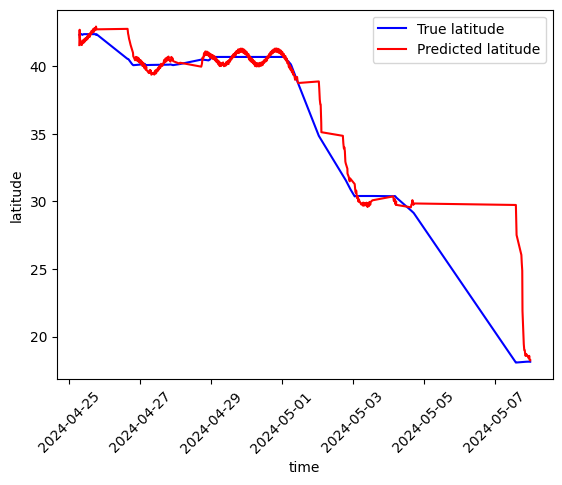

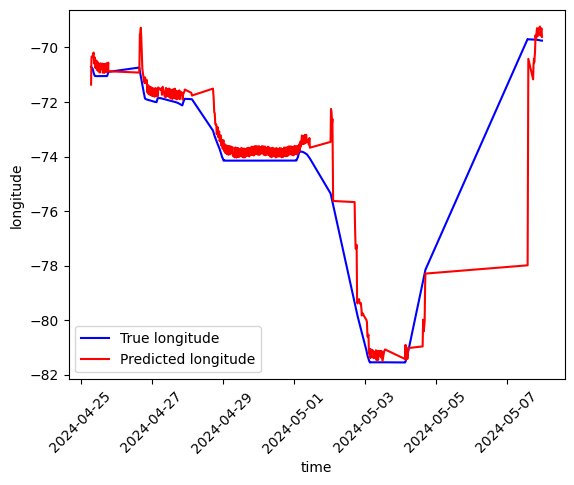

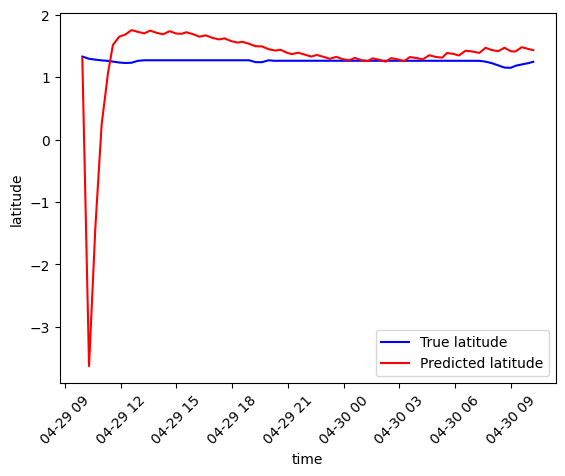

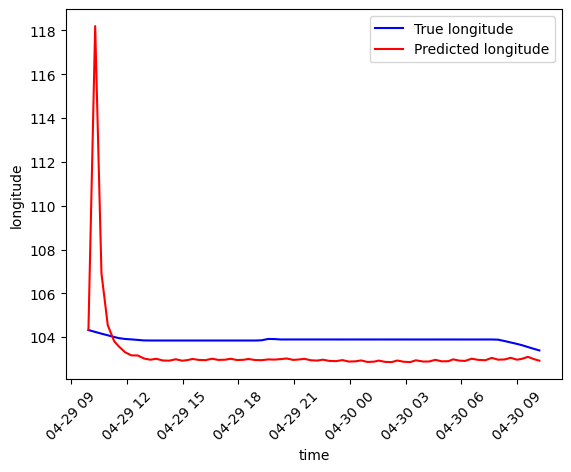

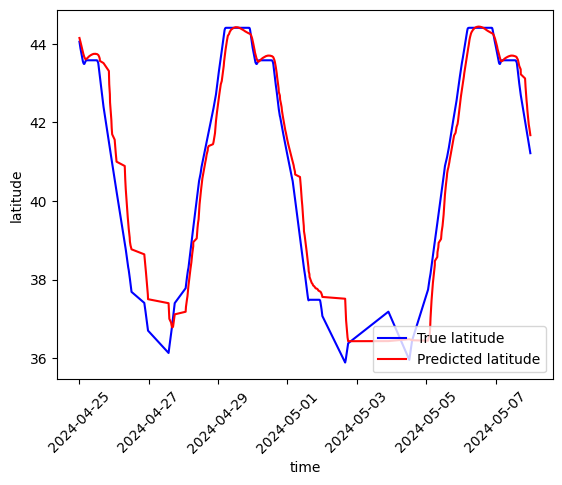

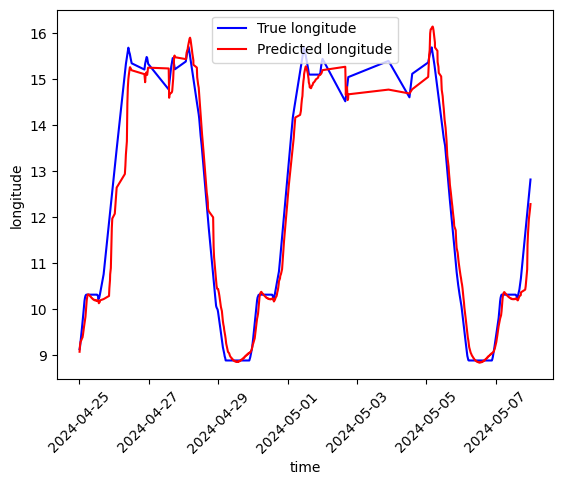

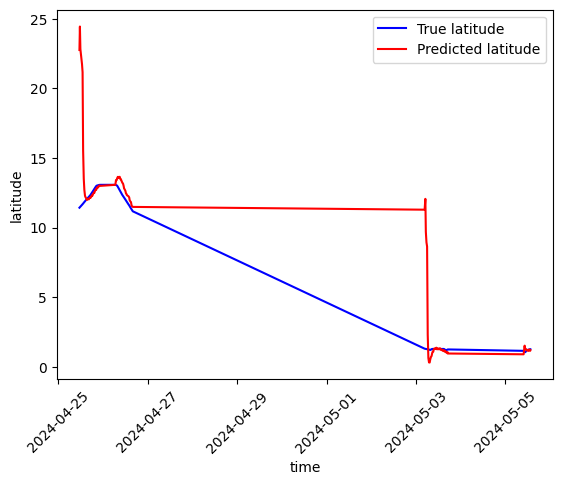

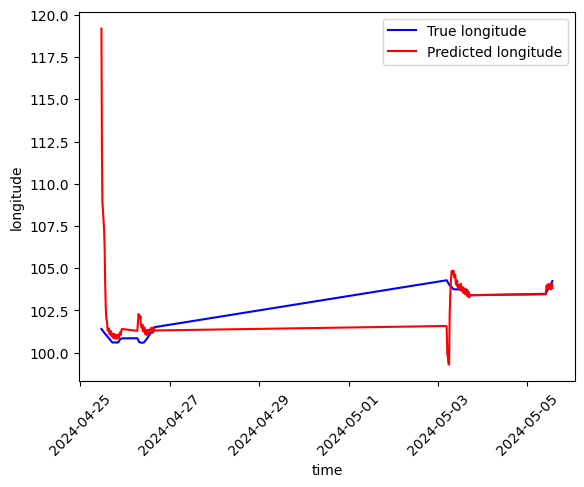

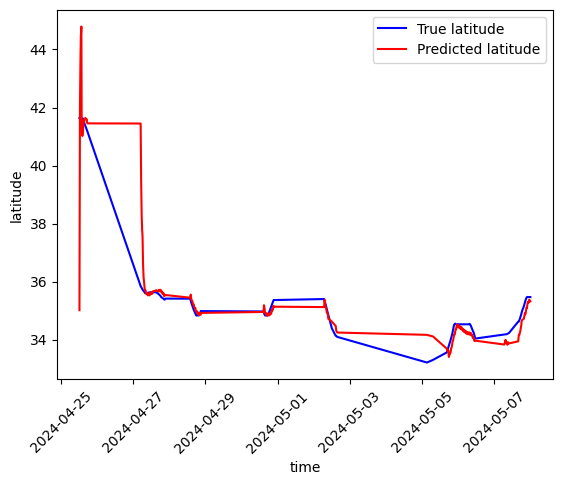

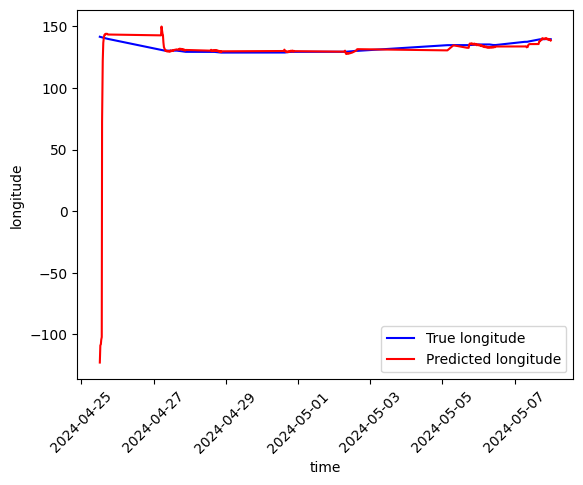

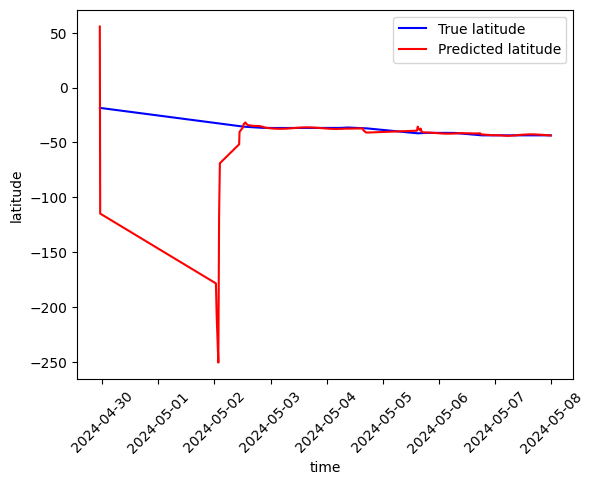

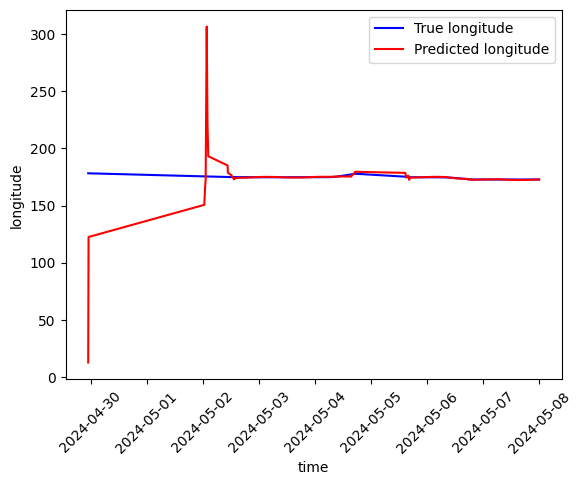

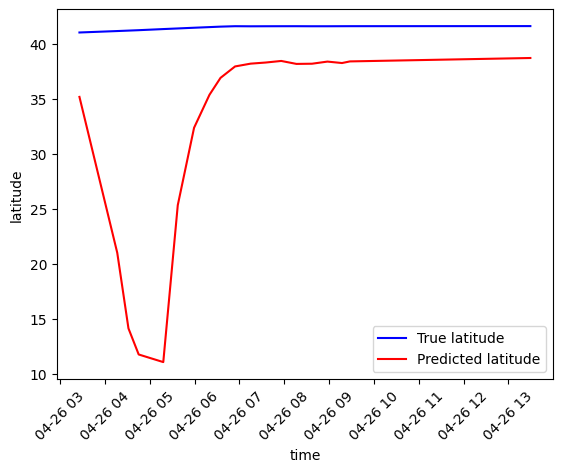

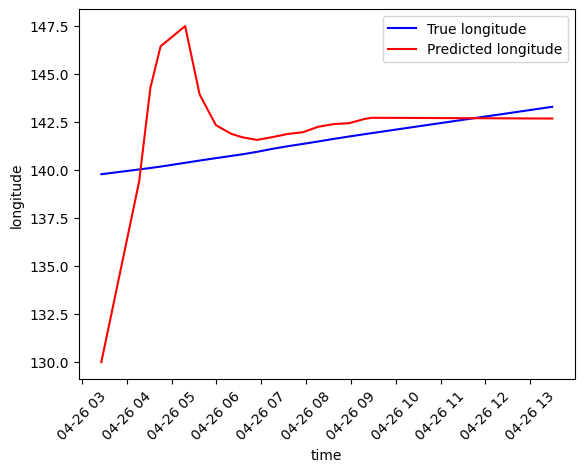

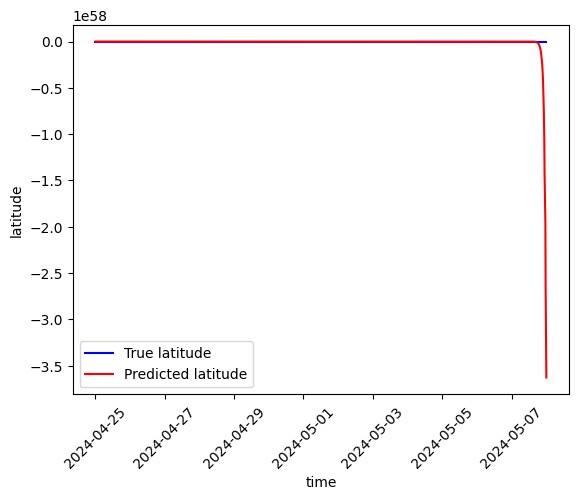

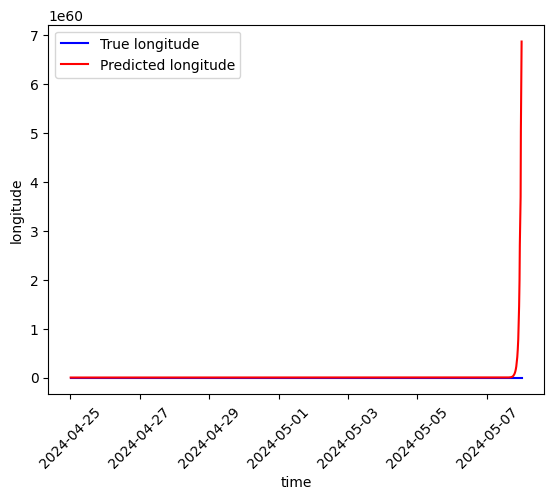

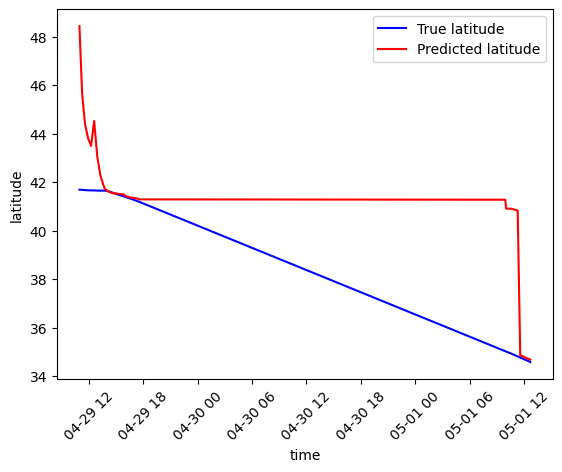

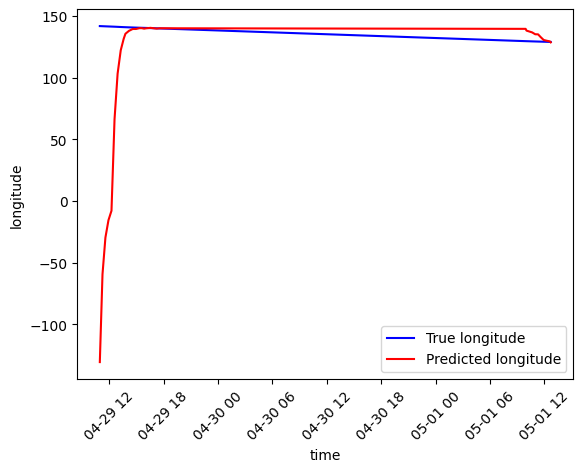

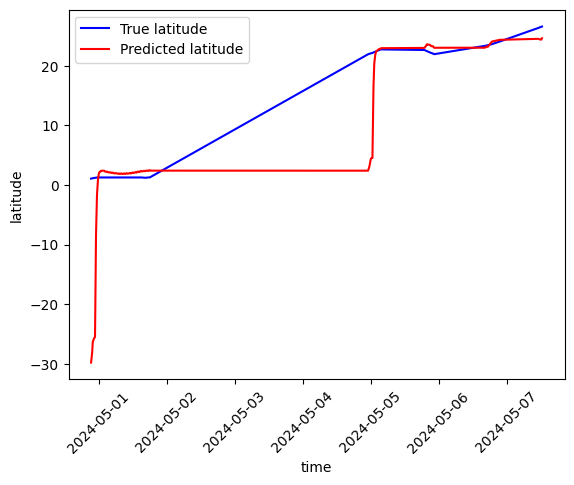

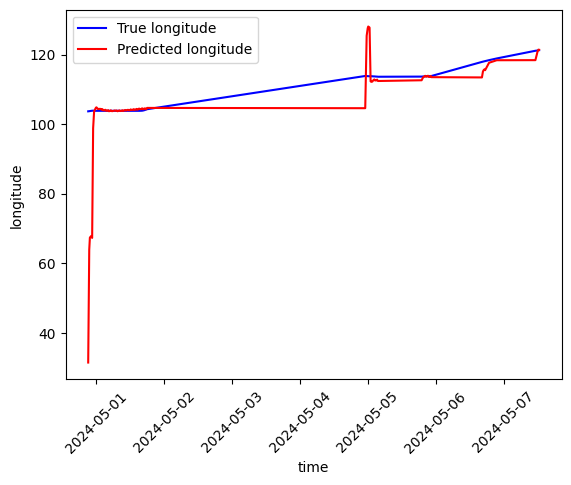

In [67]:
print(y_pred.columns)
print(y_test.columns)

for vessel_id in y_pred['vesselId'].unique():
    for feature in ['latitude', 'longitude']: # in lag_feature
        plt.plot(y_test[y_test['vesselId'] == vessel_id]['time'], y_test[y_test['vesselId'] == vessel_id][feature], label=f'True {feature}', color='blue')
        plt.plot(y_pred[y_pred['vesselId'] == vessel_id]['time'], y_pred[y_pred['vesselId'] == vessel_id][feature], label=f'Predicted {feature}', color='red')
        plt.xticks(rotation=45)
        plt.xlabel('time')
        plt.ylabel(feature)
        plt.legend()
        plt.show()


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Drop the time column from y_test and y_pred
y_test_values = y_test.drop(columns='time')
y_pred_values = y_pred.drop(columns='time')

# Calculate Mean Absolute Error (MAE) for latitude and longitude
mae = mean_absolute_error(y_test_values[['latitude', 'longitude']], y_pred_values[['latitude', 'longitude']])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_values[['latitude', 'longitude']], y_pred_values[['latitude', 'longitude']])
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')



"""
First true result:
Mean Absolute Error (MAE): 144.74297616461251
Mean Squared Error (MSE): 153729.17231131133
Root Mean Squared Error (RMSE): 392.08311913586806


Addad cos and sin hour and minutes:
Mean Absolute Error (MAE): 32.24486859767559
Mean Squared Error (MSE): 3933.24368943852
Root Mean Squared Error (RMSE): 62.71557772546244

Changed to lat and long only:
Mean Absolute Error (MAE): 0.2509074275080679
Mean Squared Error (MSE): 0.15327578600297276
Root Mean Squared Error (RMSE): 0.3915045159419911

Added week, bigger error:
Mean Absolute Error (MAE): 0.2824689055554052
Mean Squared Error (MSE): 0.1859583316950395
Root Mean Squared Error (RMSE): 0.4312288623167975


For all vessels for the first time, individual training and prediction:
Mean Absolute Error (MAE): 49.84777176376039
Mean Squared Error (MSE): 28463.945739829258
Root Mean Squared Error (RMSE): 168.71261286527826

After normalisation, not much better really:
Mean Absolute Error (MAE): 50.000008290573675
Mean Squared Error (MSE): 28514.141507704346
Root Mean Squared Error (RMSE): 168.861308498141
"""

Mean Absolute Error (MAE): 5.747257087908119e+57
Mean Squared Error (MSE): 2.2638764917244488e+118
Root Mean Squared Error (RMSE): 1.5046183874074013e+59


'\nFirst true result:\nMean Absolute Error (MAE): 144.74297616461251\nMean Squared Error (MSE): 153729.17231131133\nRoot Mean Squared Error (RMSE): 392.08311913586806\n\n\nAddad cos and sin hour and minutes:\nMean Absolute Error (MAE): 32.24486859767559\nMean Squared Error (MSE): 3933.24368943852\nRoot Mean Squared Error (RMSE): 62.71557772546244\n\nChanged to lat and long only:\nMean Absolute Error (MAE): 0.2509074275080679\nMean Squared Error (MSE): 0.15327578600297276\nRoot Mean Squared Error (RMSE): 0.3915045159419911\n\nAdded week, bigger error:\nMean Absolute Error (MAE): 0.2824689055554052\nMean Squared Error (MSE): 0.1859583316950395\nRoot Mean Squared Error (RMSE): 0.4312288623167975\n\n\nFor all vessels for the first time, individual training and prediction:\nMean Absolute Error (MAE): 49.84777176376039\nMean Squared Error (MSE): 28463.945739829258\nRoot Mean Squared Error (RMSE): 168.71261286527826\n\nAfter normalisation, not much better really:\nMean Absolute Error (MAE): 5